<a href="https://colab.research.google.com/github/Flashy990/DNN-and-CNN-Image-Classification-Models-and-Explainability/blob/main/DNN_and_CNN_Image_Classification_Model_and_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

# Setting up device to use (CPU OR GPU)

In [2]:
# Setup device agnostic code
# use cude if available, else use cpu
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Setting up accuracy_fn, train_step, test_step, print_train_time, and make_predictions

In [4]:
# importing accuracy_fn from helper_functions.py on github

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


# Import accuracy metric
from helper_functions import accuracy_fn

In [5]:
#####################################
# train_step and test_step functions
#####################################
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """
    Performs a single training step.

    Args:
    - model (torch.nn.Module): The model to be trained.
    - data_loader (torch.utils.data.DataLoader): The data loader.
    - loss_fn (torch.nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer.
    - accuracy_fn: The accuracy function.
    - device (torch.device, optional): The device to use for training. Defaults to device.

    Returns:
    - None
    """
    # initialize train loss and accuracy
    train_loss, train_acc = 0, 0
    # move the model to device
    model.to(device)

    # loop over each batch from the dataloader
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # Forward pass: compute predicted y by passing x to the model
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # print these metrics
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """
    This function performs a test step on the given model.

    Args:
    - data_loader (torch.utils.data.DataLoader): The DataLoader for the test data.
    - model (torch.nn.Module): The model to be tested.
    - loss_fn (torch.nn.Module): The loss function to be used.
    - accuracy_fn: The function to calculate the accuracy.
    - device (torch.device, optional): The device to run the model on. Defaults to the available device.

    Returns:
    - None
    """

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [6]:
from timeit import default_timer as timer
##############################################################
# function to print the difference between start and end time.
##############################################################
def print_train_time(start: float, end: float, device: torch.device = None):
    """
    This function calculates the total training time and prints it.

    Parameters:
    - start (float): The start time of the training.
    - end (float): The end time of the training.
    - device (torch.device, optional): The device on which the training was performed. Defaults to None.

    Returns:
    - total_time (float)
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [7]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):

    """
    This function makes predictions on the given data using the provided model.

    Parameters:
    - model (torch.nn.Module): The model to be used for making predictions.
    - data (list): The data on which predictions are to be made.
    - device (torch.device, optional): The device on which the model and data are to be loaded. Defaults to the available device.

    Returns:
    - torch.stack(pred_probs) (torch.tensor)
    """

    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


# Loading data and setting up DataLoader

In [8]:
#####################
# Setup training data
#####################
train_data = datasets.MNIST(
    root="data", # location to store the data
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # to turn into Torch tensors
    target_transform=None
)
####################
# Setup testing data
####################
test_data = datasets.MNIST(
    root="data", # location to store the data
    train=False, # get test data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor()  # to turn into Torch tensors
)

100%|██████████| 9912422/9912422 [00:00<00:00, 109572683.71it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27612421.66it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28615192.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7734684.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [9]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [10]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [11]:
# Print the different classes in the current dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

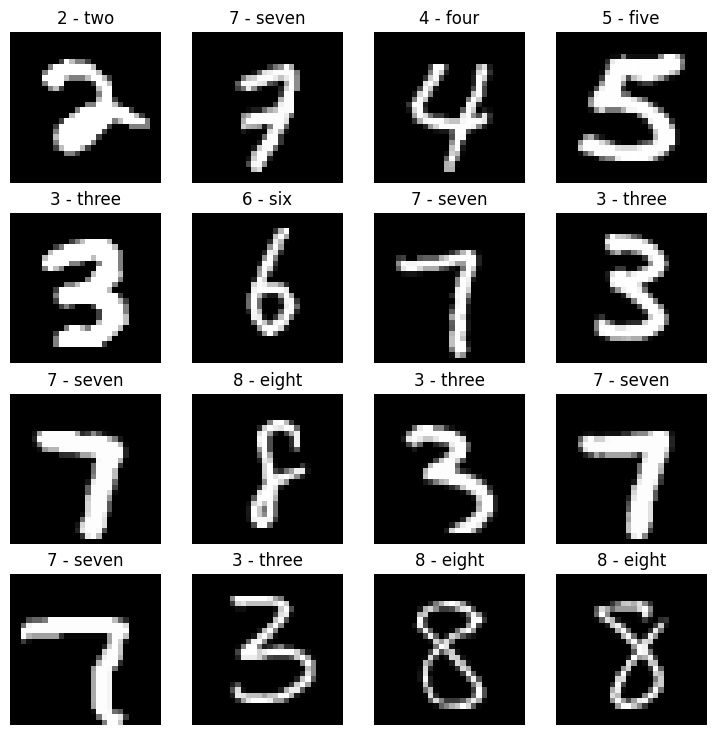

In [12]:
# Plot images of the dataset
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True # shuffle data every epoch
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f94e0608070>, <torch.utils.data.dataloader.DataLoader object at 0x7f94e0609a50>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


# Building a DNN model

In [14]:
# Create a model with non-linear and linear layers
class DigitMNISTModel_DNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [15]:
DNN_model = DigitMNISTModel_DNN(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
DNN_model

DigitMNISTModel_DNN(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [16]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=DNN_model.parameters(),
                             lr=0.1)

In [17]:
# measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=DNN_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=DNN_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.02833 | Train accuracy: 63.07%
Test loss: 0.58097 | Test accuracy: 81.84%

Epoch: 1
---------
Train loss: 0.53742 | Train accuracy: 81.92%
Test loss: 0.47851 | Test accuracy: 83.51%

Epoch: 2
---------
Train loss: 0.49203 | Train accuracy: 82.88%
Test loss: 0.47395 | Test accuracy: 83.59%

Train time on cpu: 35.879 seconds


# Building CNN model

In [18]:
# Create a convolutional neural network
class DigitMNISTModel_CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

CNN_model = DigitMNISTModel_CNN(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
CNN_model

DigitMNISTModel_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=CNN_model.parameters(),
                             lr=0.1)

In [20]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=CNN_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=CNN_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.26927 | Train accuracy: 91.04%
Test loss: 0.06336 | Test accuracy: 97.93%

Epoch: 1
---------
Train loss: 0.06972 | Train accuracy: 97.87%
Test loss: 0.05428 | Test accuracy: 98.31%

Epoch: 2
---------
Train loss: 0.05503 | Train accuracy: 98.30%
Test loss: 0.04685 | Test accuracy: 98.48%

Train time on cpu: 169.409 seconds


# Making Predictions using the model

In [21]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (5 - five)


In [22]:
# picking the model to make predictions with
model_name = CNN_model

# Make predictions on test samples with the selected model
pred_probs= make_predictions(model=model_name,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[5.3224e-08, 1.2512e-11, 1.4971e-08, 8.4077e-06, 6.4906e-10, 9.9970e-01,
         2.2177e-06, 1.3398e-12, 1.5523e-04, 1.3410e-04],
        [1.3214e-05, 9.9633e-01, 4.1753e-05, 6.9687e-05, 1.4034e-03, 1.3288e-06,
         1.5842e-04, 4.0066e-04, 1.5769e-03, 4.2915e-06]])

In [23]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 0, 2, 1, 3, 1, 3])

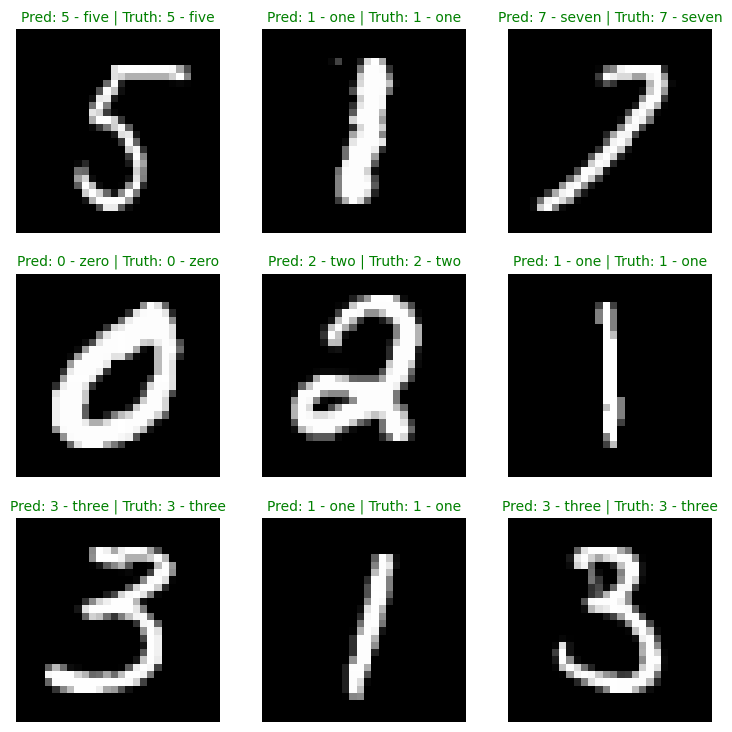

In [24]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# Shapley Explainability

In [25]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.9 MB/s eta 0:00:00


In [26]:
#https://github.com/shap/shap

torch.Size([28, 28])


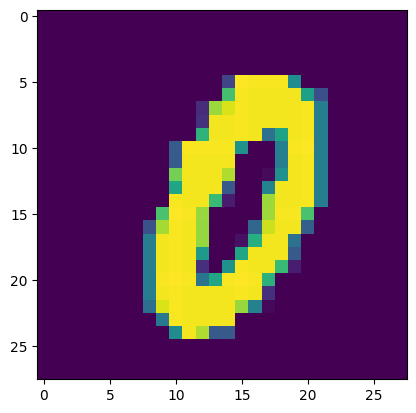

In [27]:
##########################################################
# just printing and displaying a random data item
# this is not of a lot of significance, it can be ignored
##########################################################
print(train_data.data[34].shape)
image = train_data.data[34]
plt.imshow(image)
plt.show()

unrecognized nn.Module: Flatten


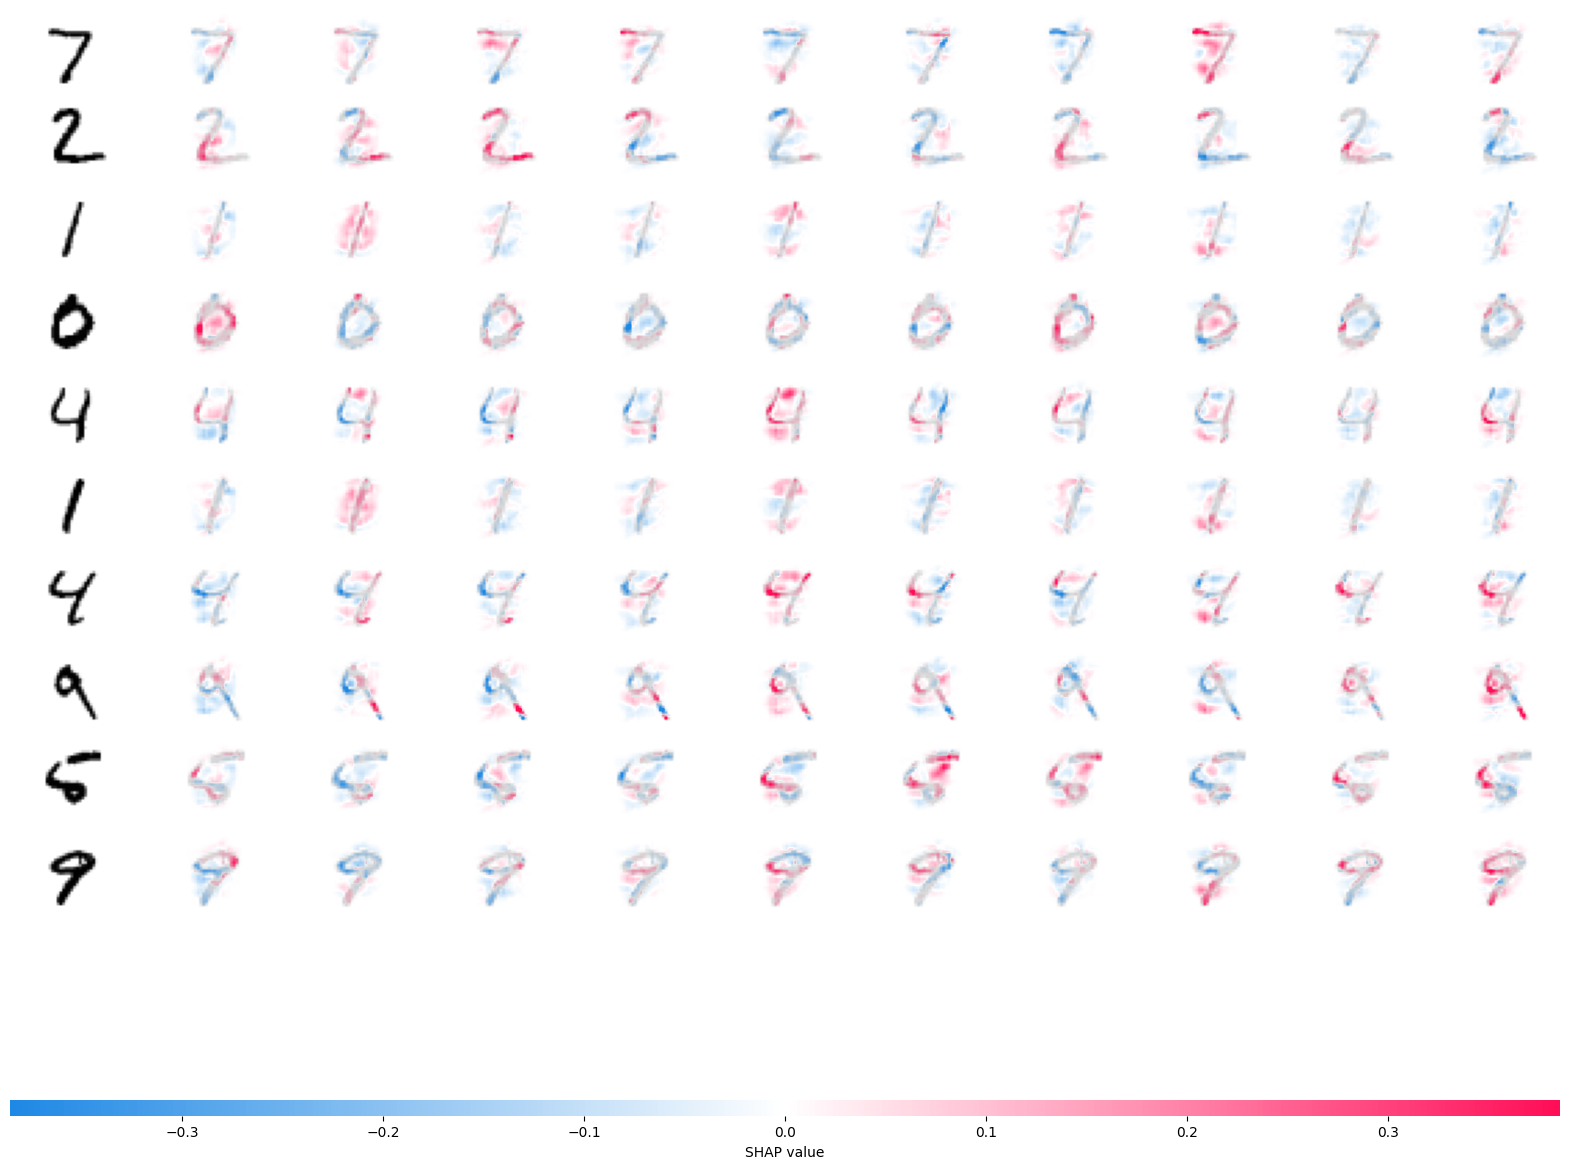

In [28]:
# since shuffle=True, this is a random sample of test data
import shap

#picking the model to use
model = CNN_model

# Select a subset of the test data for generating explanations
# The data is normalized by dividing by 255 (the maximum pixel value)
test_images = test_dataloader.dataset.data[:10].float().view(-1,1,28,28) / 255
# Select a subset of the training data to serve as the background distribution
# The background distribution is used by SHAP to calculate feature importances
background = train_dataloader.dataset.data[:100].float().view(-1,1,28,28) / 255
# Initialize the DeepExplainer object with the model and the background distribution
e = shap.DeepExplainer(model, background.to(device))
# Calculate the SHAP values for the test images
shap_values = e.shap_values(test_images.to(device))
# Rearrange the dimensions of the SHAP values and test images to match the format expected by the SHAP library's plotting function
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
# Plot the SHAP values using the SHAP library's built-in function
shap.image_plot(shap_numpy, -test_numpy)

# Reading my own image, and prediction on it


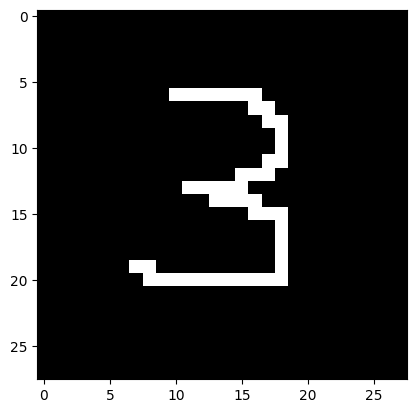

torch.Size([1, 28, 28])


In [33]:
from PIL import Image, ImageOps
img = Image.open("/content/test_img.png").convert('L').convert('1')
img2 = Image.open("/content/test_img.png").convert('L').convert('1')
#img = Image.open("/content/test_img.png")
# resize to make sure it 28x28
img = img.resize((28, 28))
# invert colors to match the mnist dataset
img = ImageOps.invert(img)

#converting to tensor and normalizing
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

input_tensor = preprocess(img)

# adding a batch dimension
input_batch = input_tensor.unsqueeze(0)


# Display the image
plt.imshow(img)
plt.show()

print(input_tensor.shape)


In [34]:
# checking prediction for the custom image, just for fun
model_name = DNN_model

# Make predictions on test samples with the selected model
pred_probs= make_predictions(model=model_name,
                             data=[input_tensor])
print(pred_probs.argmax(dim=1))



tensor([3])


# Grad-Cam for CNN model

In [ ]:
!pip install torchcam

In [ ]:
!pip install grad-cam

In [36]:
model = CNN_model
model.eval()

# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model, model.block_2[-2])

In [47]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp


# Get your input
#img = read_image("/content/test_img.png")
img = Image.open("/content/test_img.png").convert('RGB')

with SmoothGradCAMpp(model, model.block_2[-2]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  print(out)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

tensor([[ -6.7539,  -4.9942,   6.1058,  13.6079,  -7.2894,   1.7525, -10.0330,
           2.1847,   3.2408,   4.8088]], grad_fn=<AddmmBackward0>)


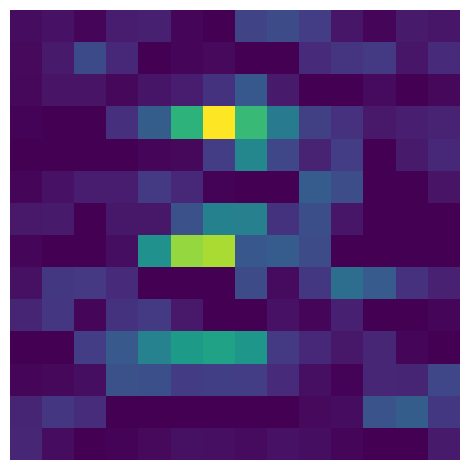

In [48]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

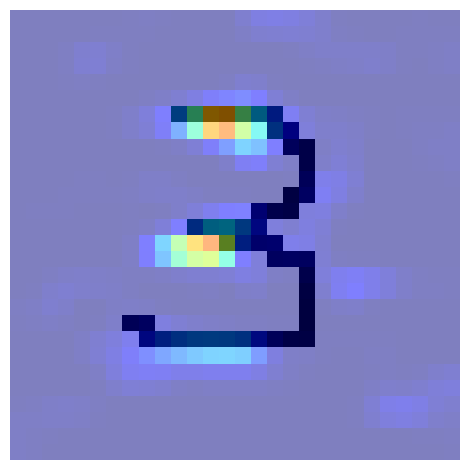

In [49]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
rgb_img2 = cv2.imread("/content/test_img.png", 1)[:, :, ::-1]

result = overlay_mask(to_pil_image(rgb_img2), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha = .5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [51]:
###################################################################
# Using framework from https://github.com/jacobgil/pytorch-grad-cam
###################################################################
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
rgb_img = cv2.imread("/content/test_img.png", 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (28, 28))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])

In [52]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

#model = resnet50(pretrained=True)

model = CNN_model
target_layers = [model.block_2[-2]]
input_tensor = input_batch # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

#targets = [ClassifierOutputTarget(281)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

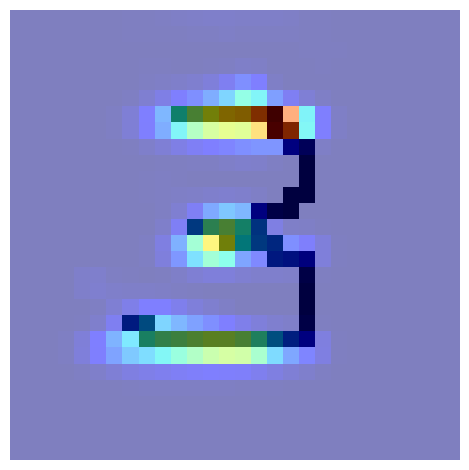

In [53]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(grayscale_cam)
rgb_img2 = cv2.imread("/content/test_img.png", 1)[:, :, ::-1]
result = overlay_mask(to_pil_image(rgb_img2), to_pil_image(grayscale_cam), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
